In [790]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np

from IPython.display import Image
from tqdm import tqdm
from sklearn.datasets import load_digits

# datasets

In [781]:
X, y = make_blobs(n_samples=50, centers=3, n_features=7, random_state=6, center_box=(-1, 1), cluster_std=0.35)

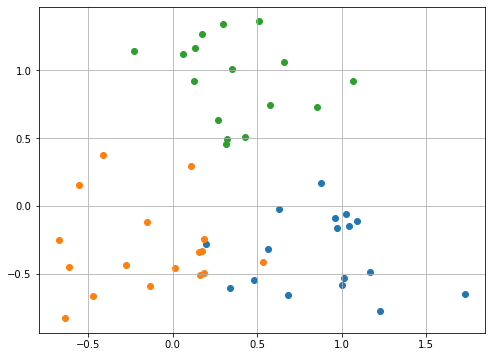

In [782]:
plt.figure(figsize=(8, 6))
for id in range(3):
    slc = X[y == id]
    plt.scatter(slc[:, 0], slc[:, 1])
plt.grid()
plt.show()

# t-SNE

https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

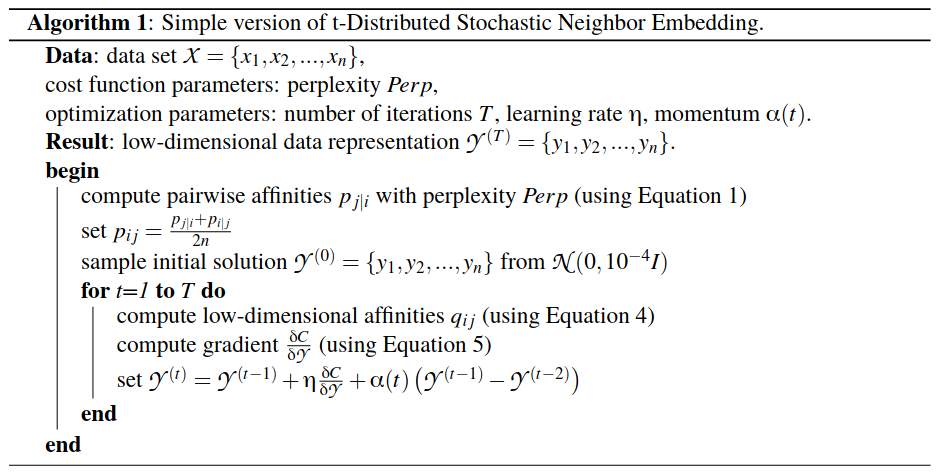

In [783]:
Image(filename='./orig_algo.png') 

Практически без циклов!

In [802]:
class SimpleTSNE:
    def __init__(self, max_iters=100, out_dims=2, learning_rate=0.1, momentum=0.9, perplexity=20):
        self.max_iters = max_iters
        self.out_dims = out_dims
        self.lr = learning_rate
        self.momentum = momentum
        self.entropy = np.log2(perplexity)
       
    def compute_local_sigmas(self, X):
        N = len(X)
        dist = ((X[np.newaxis, :, :] - X[:, np.newaxis, :])**2).sum(axis=2)
        
        answer_sigmas = []
        for i in range(N):
            sigma_min = 1e-6
            sigma_max = 1e+3
            it = 0
            while sigma_min * 1.03 < sigma_max and it < 60:
                mid = (sigma_min + sigma_max) / 2
                
                exp_dist = np.exp(-dist[i]/(2 * mid ** 2))
                p_cond = exp_dist / (exp_dist.sum() - exp_dist[i])
                
                entropy = -np.sum(p_cond * np.log2(p_cond + 1e-100))
                
                if entropy > self.entropy:
                    sigma_max = mid
                else:
                    sigma_min = mid    
            answer_sigmas.append(mid)
        return np.array(answer_sigmas)
        
    
    def fit(self, X):
        X = np.array(X)
        assert len(X.shape) == 2, "Expected 2D array"
        
        N = len(X)
        d = X.shape[1]
        
        # compute sigmas
        sigmas = self.compute_local_sigmas(X)
        
        # pairwise affinities (dist [i] == p_{*|i})       
        dist = ((X[None, :, :] - X[:, None, :]) ** 2).sum(axis=2)
        exp_dist = np.exp(- dist / (2 * (sigmas[:, None] ** 2)))
        p_ij_cond = exp_dist / (exp_dist.sum(1) - exp_dist.diagonal()) # good
        np.fill_diagonal(p_ij_cond, 0.0)
            
        # joint proba
        p_ij_joint = (p_ij_cond + p_ij_cond.T) / (2 * N)
        
        # sample init solution
        mean = np.zeros(self.out_dims)
        cov = 1e-4 * np.eye(self.out_dims)
        solution = np.random.multivariate_normal(mean, cov, N)
        solution_momentum = solution.copy()
        
        for it in tqdm(range(self.max_iters)):
            # low dimensional affinities
            q_dist = 1.0 / (1.0 + ((solution[None, :, :] - solution[:, None, :]) ** 2).sum(axis=2))
            q_ij_joint = q_dist / (q_dist.sum() - q_dist.diagonal().sum())  
            np.fill_diagonal(q_ij_joint, 0.0)
            
            # gradients
            PQ_diff = p_ij_joint - q_ij_joint
            grads = np.zeros_like(solution)
            for i in range(N):
                grads[i] = (4.0 * PQ_diff[i, :, None] * (solution[i] - solution) * (q_dist[i, :, None])).sum(axis=0)
            
            # gradient descent
            new_solution = solution - self.lr * grads - self.momentum * (solution - solution_momentum)
            solution, solution_momentum = new_solution, solution 
        
        return solution

In [785]:
X_embed = SimpleTSNE(max_iters=200, learning_rate=1, perplexity=20).fit(X)

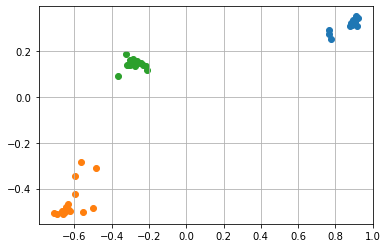

In [786]:
for it in range(3):
    slc = X_embed[y == it]
    plt.scatter(slc[:, 0], slc[:, 1])
plt.grid()
plt.show()

# more serious data

In [791]:
digits = load_digits()
print(digits['data'].shape)

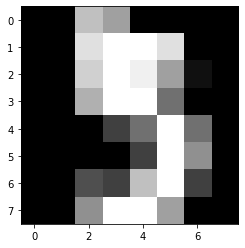

In [801]:
plt.imshow(digits.data[5].reshape(8, 8), cmap='gray')
plt.show()

In [817]:
digits_embed = SimpleTSNE(max_iters=1000, learning_rate=200, perplexity=30).fit(digits['data'] / 16)

100%|██████████| 1000/1000 [04:16<00:00,  3.89it/s]


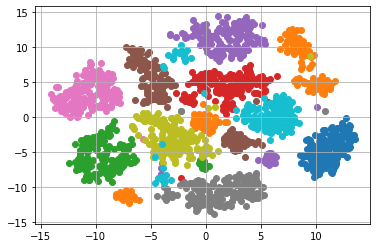

In [818]:
for it in range(10):
    slc = digits_embed[digits['target'] == it]
    plt.scatter(slc[:, 0], slc[:, 1])
plt.grid()
plt.show()

В принципе, достойно.

#### А как работает из коробки?

In [819]:
from sklearn.manifold import TSNE
outofbox_embedded = TSNE(n_components=2, method='exact').fit_transform(digits['data'] / 16)

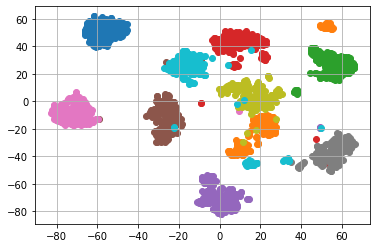

In [820]:
for it in range(10):
    slc = outofbox_embedded[digits['target'] == it]
    plt.scatter(slc[:, 0], slc[:, 1])
plt.grid()
plt.show()